In [1]:
import numpy as np
import scipy as sp
import cupy as cp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from LIFTrainingGPU import LIFTrainingGPU
from LIFTrainingGPU import create_default_params_LIF

In [3]:
p = create_default_params_LIF()
p['net_size'] = 1000
p['total_time'] = 2000
p['runtime'] = 2000
p['training_loops'] = 100
p['stim_off'] = 50
targnet = LIFTrainingGPU(p)

### first creation of saved network

In [4]:
stimr = targnet.gen_rand_stim(p) 

In [5]:
def gen_sine_targets(N, T, dt): 
    
    timesteps = int(T/dt)
    targets = np.zeros((N, timesteps))
    for i in range(N):
        amp = sp.stats.uniform.rvs() + 0.5
        t0 = sp.stats.uniform.rvs() * 2000
        t1 = sp.stats.uniform.rvs() * 1500 + 500
        x = np.linspace(0, T, num = timesteps)
        targets[i] = amp * np.sin(2 * np.pi * (x - t0)/t1)
    fout = np.zeros(timesteps)
    return targets, fout

In [6]:
targ, fout = gen_sine_targets(targnet.N, targnet.T, targnet.dt)

In [7]:
targnet.trainGPU_LIF(stimr, targ, fout)

training: 0
training: 20
training: 40
training: 60
training: 80


Text(0.5, 1.0, 'Behavior after training')

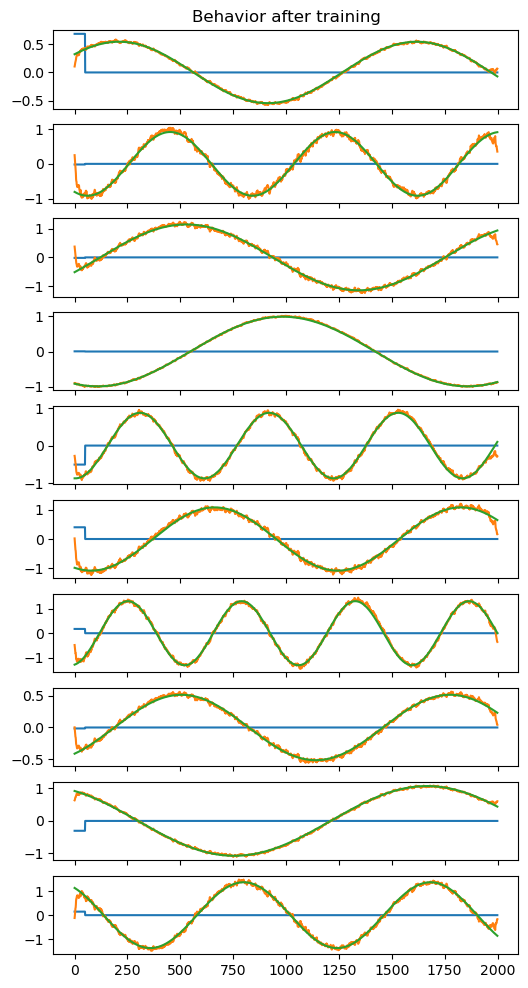

In [8]:
voltage, slow, fast = targnet.run_LIF(stimr)
Jslow = np.dot(targnet.Js, slow)

n_plot = 10
T = targnet.T
dt = targnet.dt

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(stimr[i])
    axs[i].plot(Jslow[i])
    axs[i].plot(targ[i])
axs[0].set_title("Behavior after training")

In [9]:
t = np.linspace(0, 499, 500)
tau = 100
alpha = (t/tau * np.exp(-t/tau))

95.93953114407972

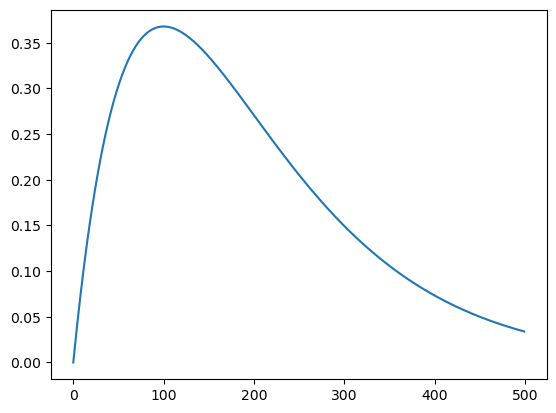

In [10]:
plt.plot(alpha)
np.sum(alpha)

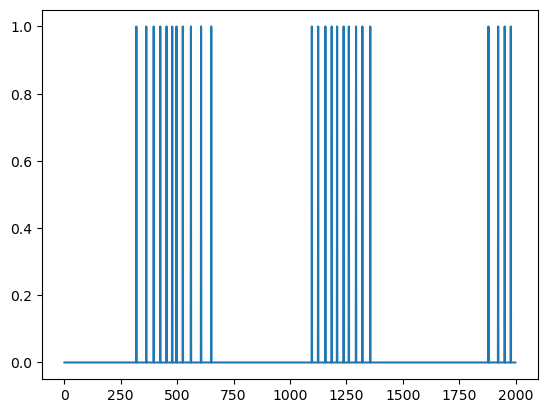

In [11]:
spks = voltage > -55
plt.plot(spks[1])

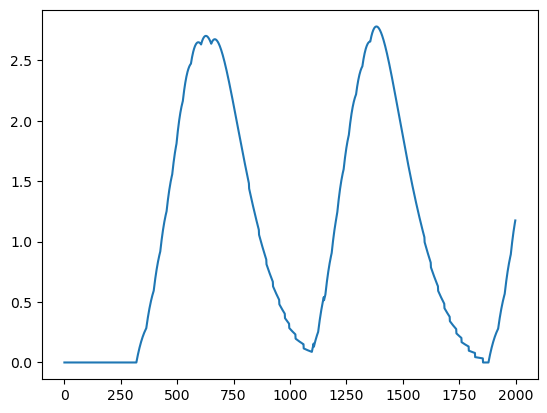

In [25]:
plt.plot(np.convolve(spks[1], alpha)[0:2000])

In [13]:
convtargs = np.zeros((1000, 2499))

In [14]:
for i in range(len(convtargs)):
    convtargs[i, :] = np.convolve(spks[i], alpha)

In [15]:
np.save("Js", targnet.Js)
np.save("Jf", targnet.Jf)
np.save("W_out", targnet.W_out)
np.save("rand_stim", stimr)
np.save("sine_targs", targ)
np.save("fout", fout)
np.save("convtargs", convtargs)

### training new networks

In [16]:
ctargs = np.load("convtargs.npy")
fout = np.load("fout.npy")

In [17]:
net = LIFTrainingGPU(p)
rstim = net.gen_rand_stim(p) 
net.trainGPU_LIF(rstim, ctargs, fout)

training: 0
training: 20
training: 40
training: 60
training: 80


In [18]:
net1 = LIFTrainingGPU(p)
rstim1 = net1.gen_rand_stim(p)
net1.trainGPU_LIF(rstim1, ctargs, fout)

training: 0
training: 20
training: 40
training: 60
training: 80


c:\Users\lab\AppData\Local\miniconda3\envs\rnns\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\lab\AppData\Local\miniconda3\envs\rnns\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


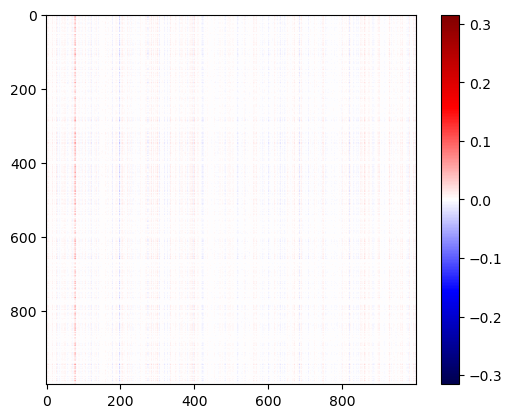

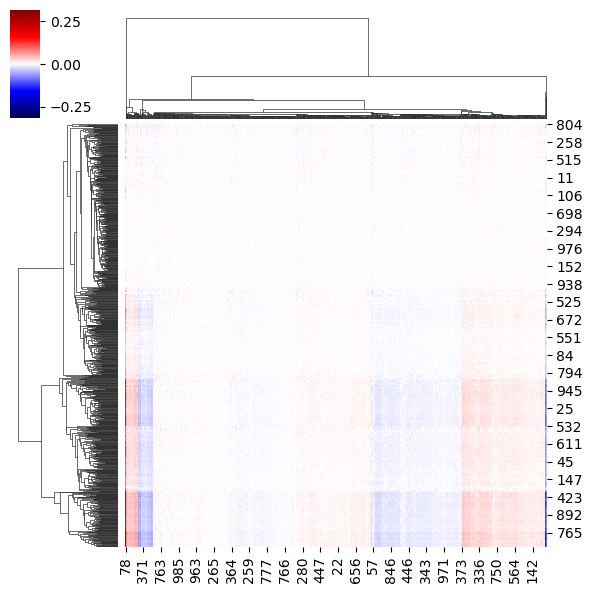

In [19]:
m = max(-1*np.min(net.Js), np.max(net.Js))
plt.imshow(net.Js, cmap=plt.get_cmap('seismic'), vmin = -m, vmax = m)
plt.colorbar()
sns.clustermap(net.Js, cmap=plt.get_cmap('seismic'), vmin = -m, vmax = m, figsize = (6, 6))

c:\Users\lab\AppData\Local\miniconda3\envs\rnns\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\lab\AppData\Local\miniconda3\envs\rnns\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


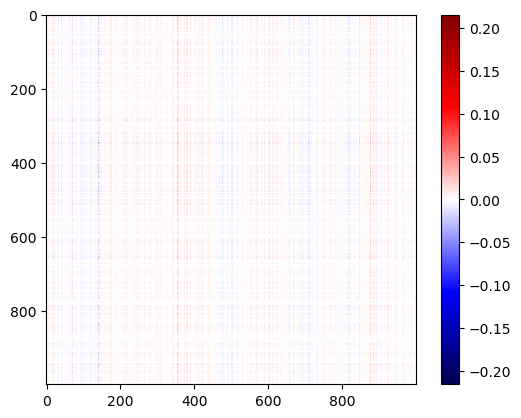

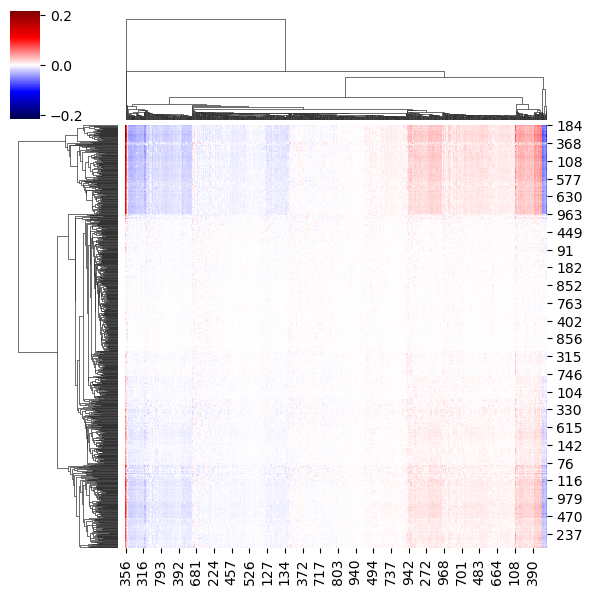

In [20]:
m1 = max(-1*np.min(net1.Js), np.max(net1.Js))
plt.imshow(net1.Js, cmap=plt.get_cmap('seismic'), vmin = -m1, vmax = m1)
plt.colorbar()
sns.clustermap(net1.Js, cmap=plt.get_cmap('seismic'), vmin = -m1, vmax = m1, figsize = (6, 6))

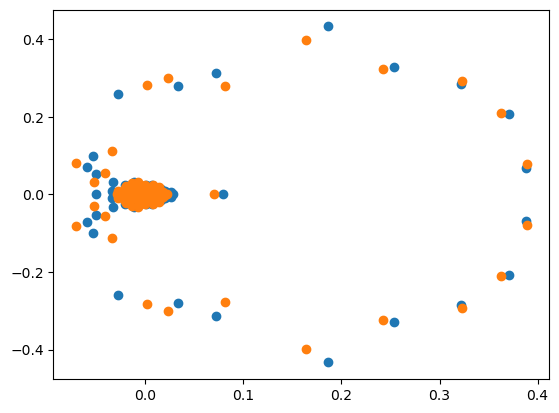

In [21]:
eigs = np.linalg.eigvals(net.Js)
eigs1 = np.linalg.eigvals(net1.Js)
plt.scatter(np.real(eigs), np.imag(eigs))
plt.scatter(np.real(eigs1), np.imag(eigs1))

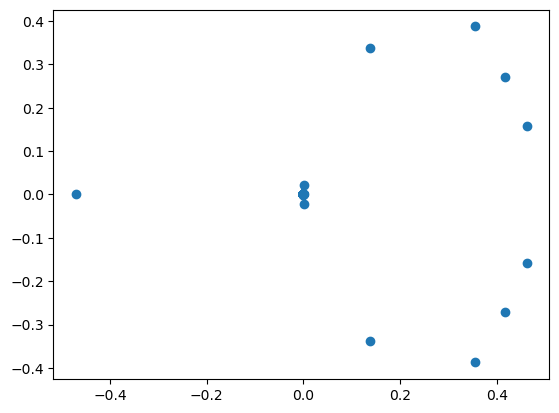

In [22]:
Js = np.load("Js.npy")
eigso = np.linalg.eigvals(Js)
plt.scatter(np.real(eigso), np.imag(eigso))

c:\Users\lab\AppData\Local\miniconda3\envs\rnns\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\lab\AppData\Local\miniconda3\envs\rnns\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


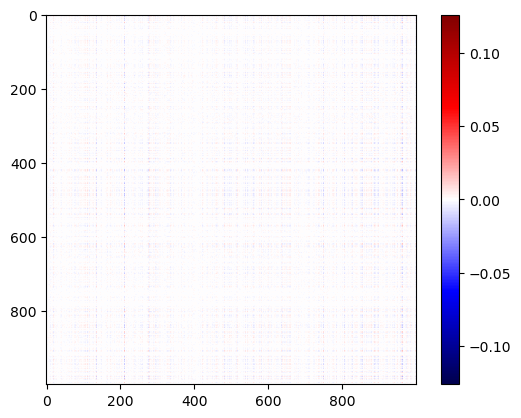

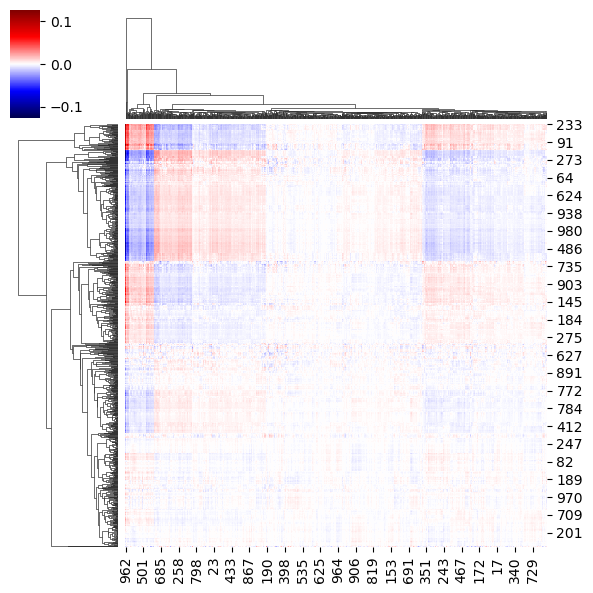

In [23]:
m0 = max(-1*np.min(Js), np.max(Js))
plt.imshow(Js, cmap=plt.get_cmap('seismic'), vmin = -m0, vmax = m0)
plt.colorbar()
sns.clustermap(Js, cmap=plt.get_cmap('seismic'), vmin = -m0, vmax = m0, figsize = (6, 6))

Text(0.5, 1.0, 'Behavior after training')

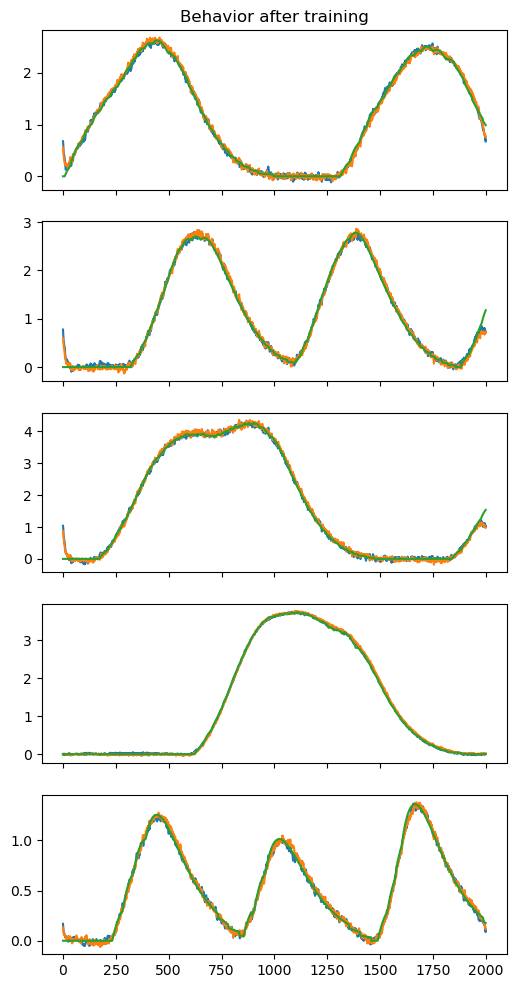

In [24]:
voltage, slow, fast = net.run_LIF(rstim)
voltage1, slow1, fast1 = net1.run_LIF(rstim1)
Jslow = np.dot(net.Js, slow)
Jslow1 = np.dot(net1.Js, slow1)

n_plot = 5
T = targnet.T
dt = targnet.dt

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(Jslow[i])
    axs[i].plot(Jslow1[i])
    axs[i].plot(ctargs[i][0:2000])
axs[0].set_title("Behavior after training")